The Two Envelope Paradox - Simulated
====
####Introduction
Bayesian statistics can most naively be described as the _art of thinking conditionally_. Conditional probability leads often to unexpected outcomes and violates our basic intuition in most surprising ways. One of the most profound violations the famous [two envelope paradox](http://en.wikipedia.org/wiki/Two_envelopes_problem).

What's the paradox?
------
The paradox can be stated in a very simple way

> You are given two identical envelopes $a$ and $b$ containing an unknown amount of money $X$. You are being told that one envelope contains twice the amount of money than the other, but you don't know which one. After choosing one envelope you are allowed to open it and decide if you want to switch. 
* Strategy 1: The situation seems absolutely symmetric, independent of which envelope you choose. As we don't know any details about the distribution we might argue that it doesn't matter if we switch - hence
\begin{align}
E( Y ) = E(X)
\end{align}

>However, after a while you start to doubt yourself, and you start thinking along a different line.
* Strategy 2: Say you choose envelope $a$ and observe an amount $X$. Then you know that with probablity $p=0.5$ the amount in envelope $b$ is $Y=2X$ or with $p=0.5$ it is $Y=X/2$. A quick calculation using conditional probability then reveals 
\begin{align}
E( Y ) = \frac{1}{2} E(Y | Y = 2X ) + \frac{1}{2} E(Y | Y = X /2 )
\end{align}
and one might quickly come to the conclusion that
\begin{align}
 \frac{1}{2} E( 2X ) + \frac{1}{2} E( X /2 )= \frac{5}{4} E(X) > E(X)
\end{align}
and you should switch the envelope as you have a statistical 25% gain from switching to envelope $b$.

Which strategy is right? It seems that the second strategy can be argued as easily with reverse roles, which would then lead to a constant switching back and forth between the envelopes.

To answer this question let's simulate the problem. First of all we need to devise a strategy after which we decide when to switch. This can be done quite simply by chosing an arbitrary threshold $T$. In the event $X<T$ we switch envelopes, otherwise we stay with the original choice

Numerical solution of the problem
------

####Python imports of the important packages

In [216]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from numpy.random import choice

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rc_params_from_file("./styles/matplotlibrc" ).update()

####Helper methods

Switching the envelopes is easy

In [217]:
def switch_envelope(chosen_envelope):
    if chosen_envelope == 'a':
        return 'b'
    else:
        return 'a'

We also need some helper methods to evaluate the success of our strategy

In [218]:
'''Find out if the final envelope _actually_ contains the highest value'''
def isLargerAmount(chosen_envelope, envelope_contents):
    inverted_contents = create_inverted_envelope(envelope_contents)
    if chosen_envelope == inverted_contents.get(np.max(inverted_contents.keys())):
        return 1 # success
    else:
        return 0 # failure
    
'''We need an inverse lookup table to associate the highest value with an envelope'''
def create_inverted_envelope(envelope_contents):
    dct = {}
    for key in envelope_contents.keys():
        dct[envelope_contents.get(key)] = key
    return dct

####Implementing the actual strategy

The strategy contains of four steps:

* create two envelopes containing iid amount of money
* choose one of them at random
* check for the money and switch if it $X<T$ where $T$ is draw from a different distribution
* evaluate if the strategy was successful

In [219]:
def singleExperiment(money_distribution, threshold_distribution):
    
    # create two identical envelopes with a random amount of money
    envelope_contents = {'a': money_distribution.random().item(),
                         'b': money_distribution.random().item()}
    
    #choose an envelope
    chosen_envelope = choice(['a','b'])
    
    #check for the amount and switch if necessary
    if (threshold_distribution.random().item() >= envelope_contents[chosen_envelope]):
        chosen_envelope = switch_envelope(chosen_envelope)
        
    #evaluate whether strategy was a success
    return isLargerAmount(chosen_envelope, envelope_contents)

####Performing the experiment

To keep it simple we draw the monetary values from a uniform distribution, whereas our random threshold is exponentially distributed.

In [220]:
money = pm.DiscreteUniform('money', 100, 100000)
threshold = pm.Exponential("threshold", 0.00005)

Let us run the experiment $n_{trials}$ times. Since we return values $1$ and $0$ for success and failure, respectively, we can find a good approximation of the success probability by computing the mean.

In [221]:
def run_n_experiments(n_trials, money, threshold):
    lst = []
    for idx in range(n_trials):
        lst.append(singleExperiment(money, threshold))
    return np.mean(lst)

In [222]:
print 'The success probability is approximately p = %0.3f' % run_n_experiments(100, money, threshold)

The success probability is approximately p = 0.650


It seems strategy 2 from above is correct! The probability is significantly higher than $0.5$ and switching seems like a good choice. How is that possible?

Resolution of the paradox
------

Looking back at strategy 2, we silently dropped the conditions when evaluating the expectation values. In fact if we let $I$ be an indicator random variable of the event $Y=2X$, then we have
\begin{align}
E( Y | Y = 2X) = E(2X | I = 1) \neq E(2X)
\end{align}

There is no reason we can drop the condition $I=1$ without ensuring that these events are independent. In fact, the above simulation shows, that they are _not_ independent. This leads us to the surprising result that observing the result of one envelope gives us information about the amount of money in the second envelope! It also shows that a naive assumption of symmetry can lead to false intuition. The symmetry argument of strategy 1 secretly assumes independence of the observations, which is clearly violated.

####Mathematical resolution of the paradox

To base the resolution is a little more formal description, we denote the observed amount of money of as $x_a$ and $x_b$ and can safely assume $x_a<x_b$. We switch the envelopes in the event $T>x_a$. Let us denote the success of the strategy as event $S$ and choosing envelope $a$ as event $A$. Assuming $T\sim Expo(1)$, we have $P(S|A) = P(T>x_a) = 1-(1-e^{-x_a}) = e^{-x_a}$ and correspondingly $P(S|A^c) = P(T<x_b) = 1- e^{-x_b}$. Adding the events correctly we obtain
\begin{align}
\frac{1}{2} P(S|A) + \frac{1}{2} P(S|A^c) = \frac{1}{2} +  \frac{1}{2} \left( e^{-x_a} - e^{-x_b}\right) > \frac{1}{2}
\end{align}


Dependency on the choice of the threshold
------

The above example was very specific on the choice of our threshold. However, it is now easy to investigate how our success rate depends on the rate parameter $\lambda$ of our distribution $T\sim Expo(\lambda)$ or on the choice of the money amounts in the envelopes.

In this section we use the global money distribution

In [223]:
money = pm.DiscreteUniform('money', 100, 100000)

####Dependence on the rate parameter

We investigate the rate parameter first. To have a continous curve we need a method to repeatedly compute the success rate.

In [224]:
def createSuccessValuesFrom(rates):
    success_values = []
    for rate in rates:
        threshold = pm.Exponential("threshold", rate)
        success_values.append(run_n_experiments(1000, money, threshold))
    return success_values

Now let's create a couple of rates and plot the final result

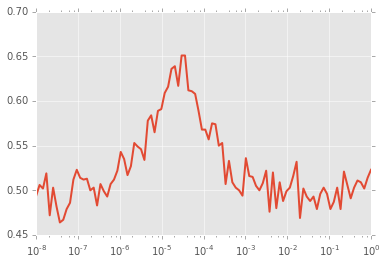

In [225]:
array_of_rates = np.logspace(-8, 0, num=100)
plt.semilogx(array_of_rates, createSuccessValuesFrom(array_of_rates))

We see that this curve is pretty noisy. To smoothen the noise, we can create a bunch of curves and average them. Alternatively we can create a bunch of success rates for every threshold rate and average them.

In [226]:
def averageSuccessRate(threshold, number_of_repetitions):
    trial = 0
    lst = []
    while trial < number_of_repetitions:
        lst.append(run_n_experiments(100, money, threshold))
        trial += 1
    return np.mean(lst), np.std(lst)

def createSmoothSuccessValuesFrom(rates, number_of_repetitions):
    success_values = []
    stddev = []
    for rate in rates:
        threshold = pm.Exponential("threshold", rate)        
        success_values.append(averageSuccessRate(threshold, number_of_repetitions)[0])
        stddev.append(averageSuccessRate(threshold, number_of_repetitions)[1])
    return success_values, stddev

Let's plot the results!

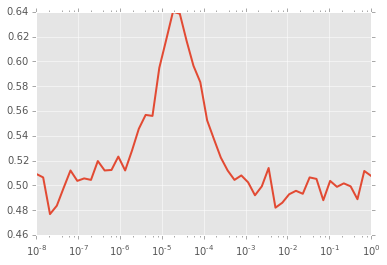

In [227]:
array_of_rates = np.logspace(-8, 0, num=50)
smoothened_rates = createSmoothSuccessValuesFrom(array_of_rates, 25)
plt.semilogx(array_of_rates, smoothened_rates[0])

We see that after the noise reduction we still have a pronounced feature. To fully appreciate that let's see what the deviation from the mean is for an eyeballed optimal rate of $\lambda = 2\, 10^{-5}$

In [228]:
threshold = pm.Exponential('threshold', 0.00002)
print 'The success probability is approximately p = %0.3f +/- %0.3f ' % averageSuccessRate(threshold, 100)

The success probability is approximately p = 0.629 +/- 0.043 


We win! Even within a standard deviation the success rate is significant.

However we also see that not every value of the threshold leads to a successful stratetgy and for the wrong values of the threshold we gain no advatange and the two envelopes seem uncorrelated again.

Dependency on the distribution of the money
------

Let us see how the distribution range for the money comes into play here. Let us do the above analysis for various different upper ranges of the money distribution.

####Uniform money distribution

In [229]:
def createSuccessValuesWithMoneyRangeFrom(rates, money):
    success_values = []
    for rate in rates:
        threshold = pm.Exponential("threshold", rate)
        success_values.append(run_n_experiments(1000, money, threshold))
    return success_values

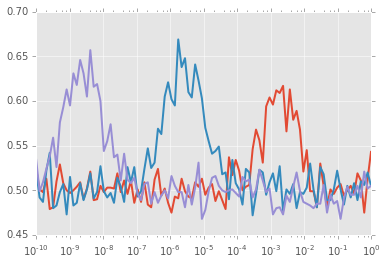

In [230]:
money_1 = pm.DiscreteUniform('money', 100, np.power(10, 3))
money_2 = pm.DiscreteUniform('money', 100, np.power(10, 6))
money_3 = pm.DiscreteUniform('money', 100000, np.power(10, 9))

array_of_rates = np.logspace(-10, 0, num=100)
plt.semilogx(array_of_rates, createSuccessValuesWithMoneyRangeFrom(array_of_rates, money_1),
             array_of_rates, createSuccessValuesWithMoneyRangeFrom(array_of_rates, money_2),
             array_of_rates, createSuccessValuesWithMoneyRangeFrom(array_of_rates, money_3))

We can clearly see that with increasing the spread of the distribution the maximum is moving towars smaller rates. In fact you can roughly say that the maximum occurs at at a rate close to the inverse of the upper boundary. This makes sense since the expectation value $E(T) = 1/\lambda$ and thus an optimal threshold choice is given by the inverse of the upper limit of the money distribution.

####Different distributions

The previous choices of the money distribution have been motivated by the idea that we have no knowledge about the value of the money in the envelope at all. This means that every value is equally likely and the natural choice is a uniform distribution.

However, what happens if we do gain some insight to the distribution? A good assumption is that the person handing out the money will do so according to a normal distribution $X\sim N(\mu, \sigma^2)$. Let's see what happens:

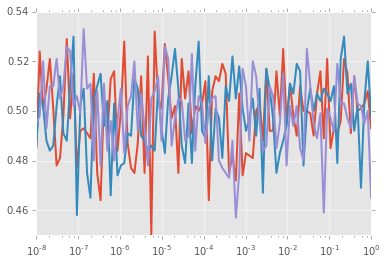

In [231]:
money_1 = pm.Normal('money', np.power(10,5), 100)
money_2 = pm.Normal('money', np.power(10,5), 500)
money_3 = pm.Normal('money', np.power(10,5), 10000)

array_of_rates = np.logspace(-8, 0, num=100)
plt.semilogx(array_of_rates, createSuccessValuesWithMoneyRangeFrom(array_of_rates, money_1),
             array_of_rates, createSuccessValuesWithMoneyRangeFrom(array_of_rates, money_2),
             array_of_rates, createSuccessValuesWithMoneyRangeFrom(array_of_rates, money_3))

Our advantage is gone! The fact that we do know something about the money distribution mysteriously decorrelates the envelopes and renders our strategy obsolete. We might as well stick with any envelope independent of the amount of money we find in it. However, this might not be a bad trade, since we now have a rough idea of what is in either envelope before we even open it.

Summary
------

The two-envelope paradox is quite surprising. In a first hunch we would assume that the situation is quite symmetric and that there is no chance we could potentially gain knowledge from opening an envelope. However, it turns out, that we can devise a strategy that allows us to make an optimal choice whether to switch envelopes or not. The two envelopes are correlated despite what meets the eye! However, our optimal choice hinges on the range and type of distribution. We only gain an advantage if we have zero prior knowledge of the money distribution, i.e. for a uniform. If we gain knowledge in the form of the money distribution, as is the case for the normal, our strategy is rendered useless. This might not be too bad as it probably eases our minds by making the choice easier.

I hope you enjoy this notebook and have a lot of fun playing some more with it, such as exploring different distributions and maybe strategies. Contributions are more than welcome!

###Miscellenea

####References

Stylesheets and idea from
- [1] [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

####Stylesheet

In [192]:
from IPython.core.display import HTML


def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()